In [18]:
from math import ceil

import torch
import torch.nn.functional as F
from torch.nn import Linear

from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import DenseGraphConv, GCNConv, dense_mincut_pool
from torch_geometric.utils import to_dense_adj, to_dense_batch

import sys

sys.path.append("../")
import utils

import torch

import torch
import torch.nn.functional as F
import torch_geometric as tg

from torch_geometric.loader import DataLoader
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

train_dataset = utils.GraphDataset("../data/", "GunPoint", n_quantiles=25)
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)

test_dataset = utils.GraphDataset("../data/", "GunPoint", False, n_quantiles=25)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))


class Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=16):
        super().__init__()

        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv15 = GCNConv(hidden_channels, hidden_channels)
        num_nodes = ceil(10)
        self.pool1 = Linear(hidden_channels, num_nodes)

        self.conv2 = DenseGraphConv(hidden_channels, hidden_channels)
        num_nodes = ceil(0.5 * num_nodes)
        self.pool2 = Linear(hidden_channels, num_nodes)

        self.conv3 = DenseGraphConv(hidden_channels, hidden_channels)
        self.conv4 = DenseGraphConv(hidden_channels, hidden_channels)

        self.lin1 = Linear(hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if data.edge_attr is not None:
            edge_weight = data.edge_attr
        else:
            edge_weight = None
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = self.conv15(x, edge_index, edge_weight).relu()

        x, mask = to_dense_batch(x, batch)
        adj = to_dense_adj(edge_index, batch)
        s = self.pool1(x)
        x, adj, mc1, o1 = dense_mincut_pool(x, adj, s, mask)

        x = self.conv2(x, adj).relu()
        s = self.pool2(x)
        x, adj, mc2, o2 = dense_mincut_pool(x, adj, s)

        x = self.conv3(x, adj)
        x = self.conv4(x, adj)

        x = x.mean(dim=1)
        x = self.lin1(x).relu()
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1), mc1 + mc2, o1 + o2

(50, 150)
(150, 150)


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net(1, 2, hidden_channels=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, patience=5, mode="min", cooldown=2, factor=0.1, verbose=True
# )

In [20]:
def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        y_out, mc_loss, o_loss = model(data)
        loss = F.nll_loss(y_out, data.y) + mc_loss + o_loss
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def test(loader):
    model.eval()
    y_pred = []
    y_true = []
    loss = 0
    for data in loader:
        y_out, mc_loss, o_loss = model(data)
        y_pred.append(y_out.argmax(dim=-1))
        y_true.append(data.y)
        loss += float(F.nll_loss(y_out, data.y) * data.num_graphs + mc_loss + o_loss)
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)
    return (
        f1_score(y_true=y_true, y_pred=y_pred, average="macro"),
        accuracy_score(y_true=y_true, y_pred=y_pred),
        loss / len(loader.dataset),
    )

In [21]:
best_macro_f1 = -1

In [24]:
# train_losses=[]
# val_losses=[]
for epoch in range(200):
    train()
    train_macro_f1, train_acc, train_loss = test(train_loader)
    test_macro_f1, test_acc, test_loss = test(test_loader)
    # scheduler.step(train_loss)
    print(
        f"Epoch: {epoch:03d}, Train_Loss: {train_loss:02.4f},Test_Loss: {test_loss:02.4f},Train_f1: {train_macro_f1:01.4f},Test_f1: {test_macro_f1:01.4f},Train_acc: {train_acc:01.4f},Test_acc: {test_acc:01.4f}"
    )
    if test_macro_f1 > best_macro_f1:
        best_accuracy = test_macro_f1
        best_epoch = epoch
        torch.save(model.state_dict(), "../data/best_model.pth")
    train_losses.append(train_loss)
    val_losses.append(test_loss)

Epoch: 000, Train_Loss: 0.6548,Test_Loss: 0.6524,Train_f1: 0.5398,Test_f1: 0.5806,Train_acc: 0.5400,Test_acc: 0.5867
Epoch: 001, Train_Loss: 0.6540,Test_Loss: 0.6518,Train_f1: 0.5593,Test_f1: 0.5988,Train_acc: 0.5600,Test_acc: 0.6067
Epoch: 002, Train_Loss: 0.6531,Test_Loss: 0.6512,Train_f1: 0.5398,Test_f1: 0.5928,Train_acc: 0.5400,Test_acc: 0.6000
Epoch: 003, Train_Loss: 0.6523,Test_Loss: 0.6506,Train_f1: 0.5398,Test_f1: 0.5806,Train_acc: 0.5400,Test_acc: 0.5867
Epoch: 004, Train_Loss: 0.6514,Test_Loss: 0.6499,Train_f1: 0.5398,Test_f1: 0.5928,Train_acc: 0.5400,Test_acc: 0.6000
Epoch: 005, Train_Loss: 0.6505,Test_Loss: 0.6493,Train_f1: 0.5398,Test_f1: 0.5928,Train_acc: 0.5400,Test_acc: 0.6000
Epoch: 006, Train_Loss: 0.6495,Test_Loss: 0.6486,Train_f1: 0.5785,Test_f1: 0.6109,Train_acc: 0.5800,Test_acc: 0.6200
Epoch: 007, Train_Loss: 0.6485,Test_Loss: 0.6480,Train_f1: 0.5974,Test_f1: 0.6109,Train_acc: 0.6000,Test_acc: 0.6200
Epoch: 008, Train_Loss: 0.6475,Test_Loss: 0.6473,Train_f1: 0.578

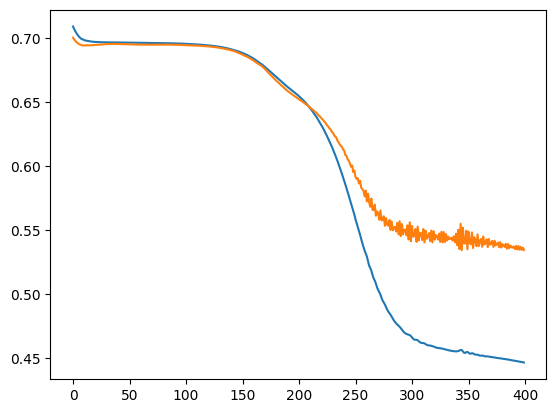

In [25]:
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.plot(val_losses)
plt.show()